## Plot mutation prediction results

In this notebook, we'll visualize the results of our mutation prediction experiments across all data types (see `README.md` for more details). The files analyzed in this notebook are generated by the `run_mutation_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff (after FDR correction)
* PLOT_AUROC (bool): if True plot AUROC, else plot AUPR

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# svgutils sometimes doesn't deal well with text as paths in svgs
# so for this file, we'll save the text as text, then convert it by hand
# in inkscape to paths which seem to work fine in svgutils
# 
# for some reason just the plots in this file have this issue, plots from
# other analysis scripts don't have this issue so we don't have to do all this
plt.rcParams['svg.fonttype'] = 'none'

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

In [2]:
# if True, plot results for merged geneset (see 00_download_data/2_download_cancer_gene_data.ipynb)
# if False, plot results for Vogelstein et al. 2013 gene set
merged_geneset = True

# if True, use "alternate" per-gene filtering method (described in 01_explore_data/count_dataset_filters.ipynb)
filter_all = False

if merged_geneset:
    if filter_all:
        results_dir = Path(cfg.results_dirs['mutation'], 'merged_filter_all', 'gene').resolve()
    else:
        results_dir = Path(cfg.results_dirs['mutation'], 'merged_all', 'gene').resolve()
else:
    results_dir = Path(cfg.results_dirs['mutation'],
                       'all_data_types_results_shuffle_cancer_type',
                       'gene').resolve()
    
# if True, save figures to ./images directory
SAVE_FIGS = True

# set significance cutoff after FDR correction
SIG_ALPHA = 0.001

# if True, plot AUROC instead of AUPR
PLOT_AUROC = False
if PLOT_AUROC:
    plot_metric = 'auroc'
    images_dir = Path(cfg.images_dirs['mutation'], 'auroc')
else:
    plot_metric = 'aupr'
    images_dir = Path(cfg.images_dirs['mutation'])

In [3]:
# load raw data
results_df = au.load_stratified_prediction_results(results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
results_df = results_df[results_df.training_data.isin(['expression', 'rppa', 'mirna', 'mut_sigs'])]

# make sure that we're correctly pointing to raw data for non-methylation data types
# and that we have data for two replicates (two random seeds)
print(results_df.shape)
print(results_df.seed.unique())
print(results_df.training_data.unique())
results_df.head()

(41376, 9)
[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs']


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment
0,0.89764,0.716580,MAP3K1,expression,signal,42,train,0,gene
1,0.44982,0.075833,MAP3K1,expression,signal,42,test,0,gene
2,0.66546,0.300290,MAP3K1,expression,signal,42,cv,0,gene
3,0.98281,0.909130,MAP3K1,expression,signal,42,train,1,gene
4,0.85560,0.564490,MAP3K1,expression,signal,42,test,1,gene


In [4]:
# load compressed data for me_27k and me_450k
compressed_results_df = au.load_compressed_prediction_results(results_dir, 'gene')

# make sure that we're correctly pointing to compressed methylation data
# and that we have data for one dimension and two replicates (two random seeds)
print(compressed_results_df.shape)
print(compressed_results_df.seed.unique())
print(compressed_results_df.training_data.unique())
print(compressed_results_df.n_dims.unique())
compressed_results_df.head()

(20688, 10)
[ 1 42]
['me_450k' 'me_27k']
[5000]


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,n_dims,experiment
0,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,0,5000,gene
1,0.81326,0.45134,MAP3K1,me_450k,signal,1,test,0,5000,gene
2,0.65695,0.28388,MAP3K1,me_450k,signal,1,cv,0,5000,gene
3,1.00000,1.00000,MAP3K1,me_450k,signal,1,train,1,5000,gene
4,0.73856,0.45058,MAP3K1,me_450k,signal,1,test,1,5000,gene


In [5]:
results_df['n_dims'] = 'raw'
results_df = pd.concat((results_df, compressed_results_df))
print(results_df.seed.unique())
print(results_df.training_data.unique())
print(results_df.n_dims.unique())
print(results_df.shape)
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}
results_df.training_data.replace(to_replace=training_data_map, inplace=True)
results_df.head()

[42  1]
['expression' 'mirna' 'rppa' 'mut_sigs' 'me_450k' 'me_27k']
['raw' 5000]
(62064, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.89764,0.716580,MAP3K1,gene expression,signal,42,train,0,gene,raw
1,0.44982,0.075833,MAP3K1,gene expression,signal,42,test,0,gene,raw
2,0.66546,0.300290,MAP3K1,gene expression,signal,42,cv,0,gene,raw
3,0.98281,0.909130,MAP3K1,gene expression,signal,42,train,1,gene,raw
4,0.85560,0.564490,MAP3K1,gene expression,signal,42,test,1,gene,raw


In [6]:
all_results_df = au.compare_all_data_types(results_df,
                                           SIG_ALPHA,
                                           metric=plot_metric)

cfg.sig_genes_dir.mkdir(exist_ok=True)
all_results_df.to_csv(cfg.sig_genes_all, index=False, sep='\t')

all_results_df.sort_values(by='p_value').head(10)

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
23,BRAF,0.308046,6.123121e-10,1.328717e-07,True,27k methylation,6.876567
45,CIC,0.647034,1.880651e-09,4.081014e-07,True,450k methylation,6.389232
60,ERBB2,0.312735,2.905854e-09,3.152852e-07,True,27k methylation,6.501296
45,CIC,0.645135,3.558277e-09,7.721461e-07,True,gene expression,6.112301
56,EGFR,0.531508,9.779722e-09,8.999793e-07,True,gene expression,6.045767
60,ERBB2,0.537138,1.339592e-08,8.999793e-07,True,gene expression,6.045767
168,PTEN,0.229569,1.460109e-08,1.056146e-06,True,27k methylation,5.976276
207,TSC1,0.616890,1.745741e-08,8.999793e-07,True,gene expression,6.045767
30,CCND1,0.603684,2.073685e-08,8.999793e-07,True,gene expression,6.045767
204,TP53,0.202256,3.084420e-08,6.693192e-06,True,RPPA,5.174367


gene expression: 79/217
27k methylation: 31/217
450k methylation: 42/217


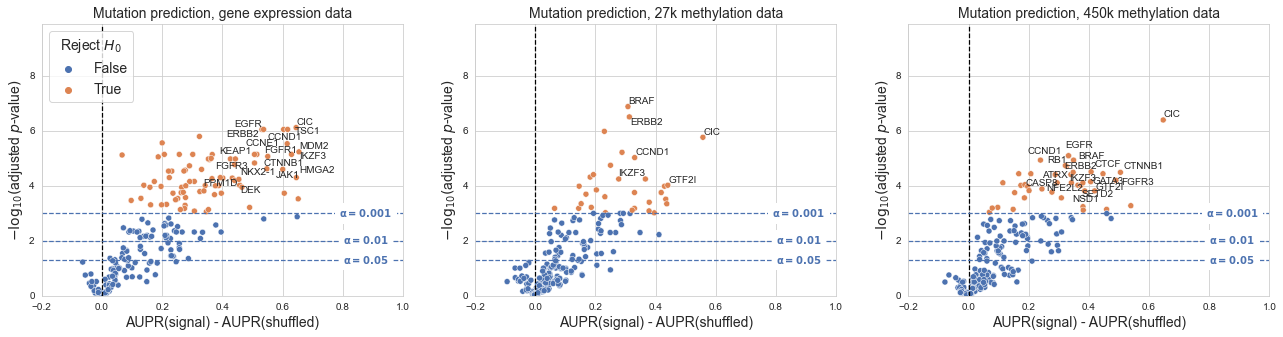

In [7]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True,
                          label_x_lower_bounds=[0.45, 0.3, 0.3],
                          label_y_lower_bounds=[4, 4, 4])

if SAVE_FIGS:
    if filter_all:
        images_dir.mkdir(exist_ok=True)
        plt.savefig(images_dir / 'all_vs_shuffled_extended_filter_all.svg', bbox_inches='tight')
        plt.savefig(images_dir / 'all_vs_shuffled_extended_filter_all.png',
                    dpi=300, bbox_inches='tight')
    else:
        images_dir.mkdir(exist_ok=True)
        plt.savefig(images_dir / 'all_vs_shuffled_extended.svg', bbox_inches='tight')
        plt.savefig(images_dir / 'all_vs_shuffled_extended.png',
                    dpi=300, bbox_inches='tight')

RPPA: 33/217
microRNA: 25/217
mutational signatures: 2/217


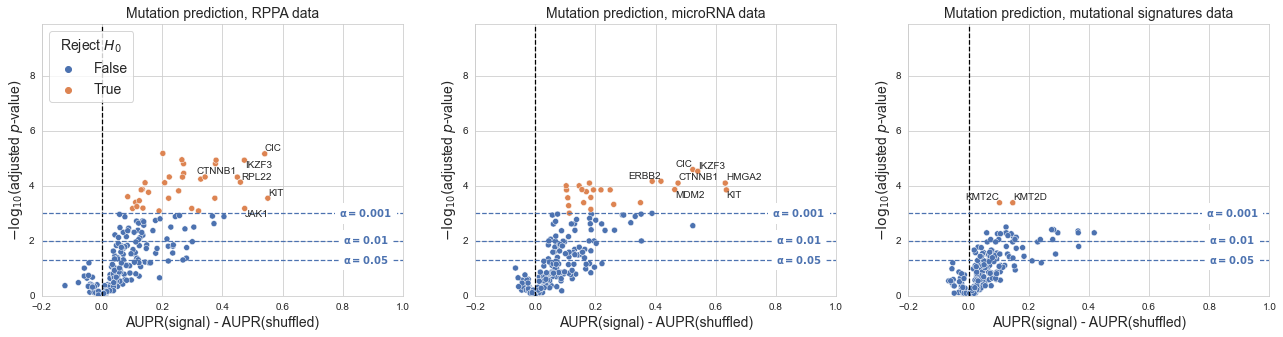

In [8]:
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 3)

# plot mutation prediction from expression, in a volcano-like plot
datasets = ['RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_baseline(all_results_df,
                          axarr,
                          filtered_data_map,
                          SIG_ALPHA,
                          metric=plot_metric,
                          verbose=True,
                          label_x_lower_bounds=[0.4, 0.4, 0],
                          label_y_lower_bounds=[3, 3, 3])
    
if SAVE_FIGS:
    if filter_all:
        plt.savefig(images_dir / 'all_vs_shuffled_filter_all.svg', bbox_inches='tight')
        plt.savefig(images_dir / 'all_vs_shuffled_filter_all.png',
                    dpi=300, bbox_inches='tight')
    else:
        plt.savefig(images_dir / 'all_vs_shuffled.svg', bbox_inches='tight')
        plt.savefig(images_dir / 'all_vs_shuffled.png',
                    dpi=300, bbox_inches='tight')

In [9]:
# map gene/training data combinations to accept/reject null
# vs. shuffled baseline
# we want to plot this info on top of -omics comparison
id_to_sig = (all_results_df
  .loc[:, ['gene', 'training_data', 'reject_null']]
  .rename(columns={'reject_null': 'reject_null_baseline'})
)

id_to_sig.head()

,gene,training_data,reject_null_baseline
0,ABL2,gene expression,False
1,ACVR2A,gene expression,False
2,AFF3,gene expression,False
3,ALK,gene expression,False
4,AMER1,gene expression,False


27k methylation: 5/30
450k methylation: 2/40


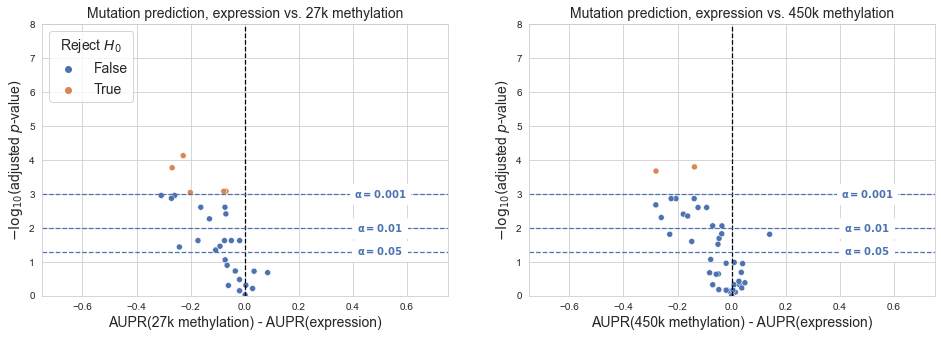

In [10]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (16, 5)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

datasets = ['gene expression', '27k methylation', '450k methylation']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

plu.plot_volcano_comparison(results_df,
                            axarr,
                            filtered_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            sig_genes=id_to_sig,
                            verbose=True,
                            add_labels=False)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_comparison_extended.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_comparison_extended.png',
                dpi=300, bbox_inches='tight')

RPPA: 6/29
microRNA: 7/24
mutational signatures: 0/2


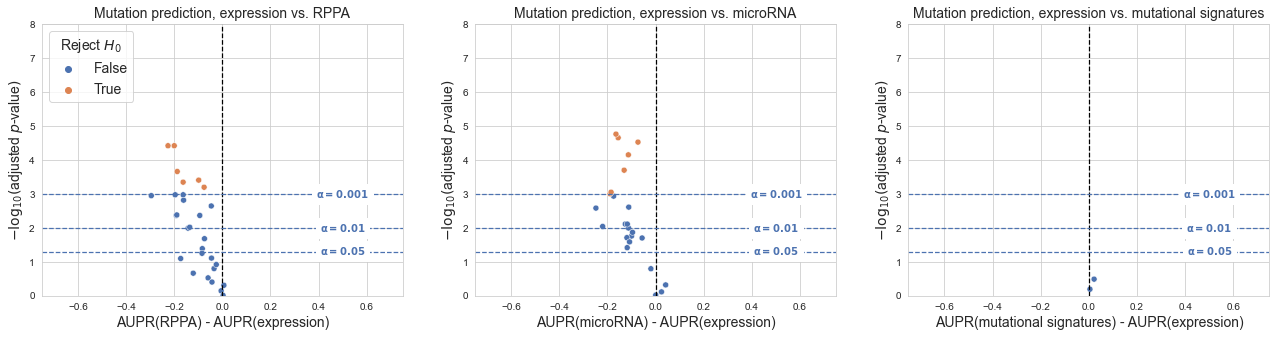

In [11]:
# compare expression against all other data modalities
# could do all vs. all, but that would give us lots of plots
sns.set({'figure.figsize': (22, 5)})
sns.set_style('whitegrid')

datasets = ['gene expression', 'RPPA', 'microRNA', 'mutational signatures']
filtered_data_map = {k: v for k, v in training_data_map.items() if v in datasets}

fig, axarr = plt.subplots(1, 3)

plu.plot_volcano_comparison(results_df,
                            axarr,
                            filtered_data_map,
                            SIG_ALPHA,
                            metric=plot_metric,
                            sig_genes=id_to_sig,
                            verbose=True,
                            add_labels=False)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_comparison.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_comparison.png',
                dpi=300, bbox_inches='tight')

(86,)
['ARID1A' 'ARNT' 'ATRX' 'BCL6' 'BCL9' 'BRAF' 'CARD11' 'CASP8' 'CCND1'
 'CCNE1' 'CDH1' 'CDKN2A' 'CIC' 'CTCF' 'CTNNB1' 'DDR2' 'DEK' 'EGFR' 'ELK4'
 'ERBB2' 'ETV5' 'FBXW7' 'FCGR2B' 'FGFR1' 'FGFR3' 'FOXA1' 'FUBP1' 'GATA3'
 'GTF2I' 'HEY1' 'HLF' 'HMGA2' 'IDH1' 'IKBKB' 'IKZF3' 'IL7R' 'JAK1' 'KAT6A'
 'KEAP1' 'KIT' 'KMT2B' 'KMT2C' 'KMT2D' 'KRAS' 'LPP' 'LRP1B' 'MACF1'
 'MAP3K13' 'MDM2' 'MECOM' 'MSI2' 'MYC' 'MYCL' 'NCOA2' 'NFE2L2' 'NKX2-1'
 'NRAS' 'NSD1' 'PBRM1' 'PBX1' 'PIK3CA' 'PPM1D' 'PPP2R1A' 'PRDM1' 'PREX2'
 'PTEN' 'RAD21' 'RB1' 'RUNX1T1' 'SMAD4' 'SOX2' 'SPOP' 'STK11' 'TERT'
 'TP53' 'TP63' 'TRRAP' 'TSC1' 'UBR5' 'FAT4' 'ERBB4' 'KMT2A' 'PIK3R1'
 'RPL22' 'KDM6A' 'SETD2']


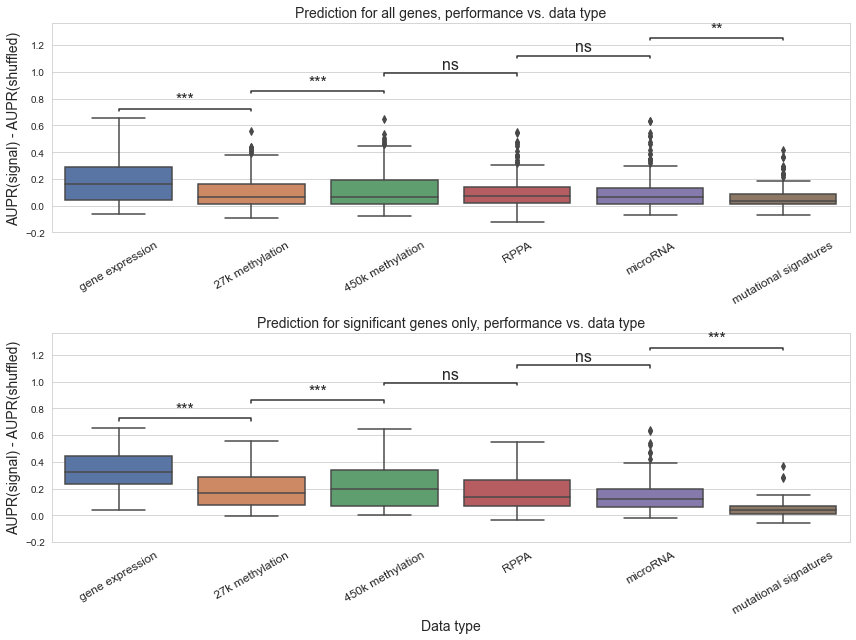

In [12]:
sns.set({'figure.figsize': (12, 9)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

tests_df = plu.plot_boxes(all_results_df,
                          axarr,
                          training_data_map,
                          metric=plot_metric,
                          orientation='v',
                          verbose=True,
                          pairwise_tests=True,
                          pairwise_box_pairs=[('gene expression', '27k methylation'),
                                              ('27k methylation', '450k methylation'),
                                              ('450k methylation', 'RPPA'),
                                              ('RPPA', 'microRNA'),
                                              ('microRNA', 'mutational signatures')])

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_boxes.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_boxes.png',
                dpi=300, bbox_inches='tight')

In [13]:
# pairwise rank sum tests comparing results distributions
# H0: results distributions are the same between the data types
tests_df.sort_values(['gene_set', 'p_value'])

,data_type_1,data_type_2,p_value,corr_pval,reject_null,gene_set
0,gene expression,27k methylation,1.230925e-20,1.846387e-19,True,all
3,gene expression,microRNA,1.493059e-20,2.239588e-19,True,all
2,gene expression,RPPA,2.534134e-17,3.801201e-16,True,all
4,gene expression,mutational signatures,2.593527e-16,3.890290e-15,True,all
1,gene expression,450k methylation,4.870724e-14,7.306086e-13,True,all
5,27k methylation,450k methylation,9.466108e-07,1.419916e-05,True,all
11,450k methylation,mutational signatures,1.989663e-06,2.984494e-05,True,all
13,RPPA,mutational signatures,1.200101e-05,1.800151e-04,True,all
8,27k methylation,mutational signatures,6.462113e-05,9.693169e-04,True,all
14,microRNA,mutational signatures,7.338690e-05,1.100804e-03,True,all


(86,)
['ARID1A' 'ARNT' 'ATRX' 'BCL6' 'BCL9' 'BRAF' 'CARD11' 'CASP8' 'CCND1'
 'CCNE1' 'CDH1' 'CDKN2A' 'CIC' 'CTCF' 'CTNNB1' 'DDR2' 'DEK' 'EGFR' 'ELK4'
 'ERBB2' 'ETV5' 'FBXW7' 'FCGR2B' 'FGFR1' 'FGFR3' 'FOXA1' 'FUBP1' 'GATA3'
 'GTF2I' 'HEY1' 'HLF' 'HMGA2' 'IDH1' 'IKBKB' 'IKZF3' 'IL7R' 'JAK1' 'KAT6A'
 'KEAP1' 'KIT' 'KMT2B' 'KMT2C' 'KMT2D' 'KRAS' 'LPP' 'LRP1B' 'MACF1'
 'MAP3K13' 'MDM2' 'MECOM' 'MSI2' 'MYC' 'MYCL' 'NCOA2' 'NFE2L2' 'NKX2-1'
 'NRAS' 'NSD1' 'PBRM1' 'PBX1' 'PIK3CA' 'PPM1D' 'PPP2R1A' 'PRDM1' 'PREX2'
 'PTEN' 'RAD21' 'RB1' 'RUNX1T1' 'SMAD4' 'SOX2' 'SPOP' 'STK11' 'TERT'
 'TP53' 'TP63' 'TRRAP' 'TSC1' 'UBR5' 'FAT4' 'ERBB4' 'KMT2A' 'PIK3R1'
 'RPL22' 'KDM6A' 'SETD2']


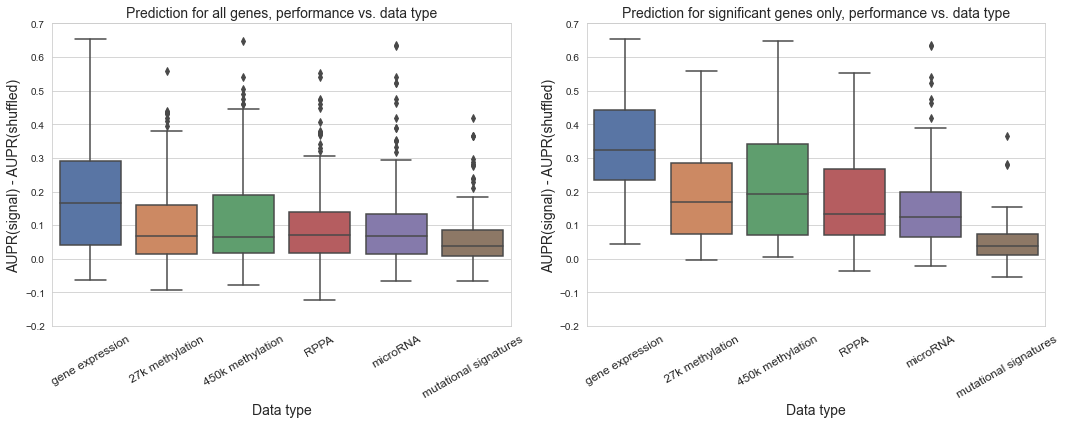

In [14]:
sns.set({'figure.figsize': (15, 6)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(1, 2)

plu.plot_boxes(all_results_df,
               axarr,
               training_data_map,
               metric=plot_metric,
               verbose=True)

In [15]:
heatmap_df = (all_results_df
    .pivot(index='training_data', columns='gene', values='delta_mean')
    .reindex(training_data_map.values())
)
heatmap_df.iloc[:, :5]

gene,ABL2,ACVR2A,AFF3,ALK,AMER1
training_data,,,,,
gene expression,0.157714,0.221802,0.099245,0.016024,-0.015359
27k methylation,0.021533,0.101549,0.008818,0.011162,0.043614
450k methylation,0.013811,0.105183,0.011419,-0.004180,-0.015803
RPPA,0.016275,0.235003,0.019743,0.051504,0.123477
microRNA,0.043491,0.195738,-0.019571,0.013703,0.026438
mutational signatures,-0.023933,0.229680,0.065552,0.024144,-0.023989


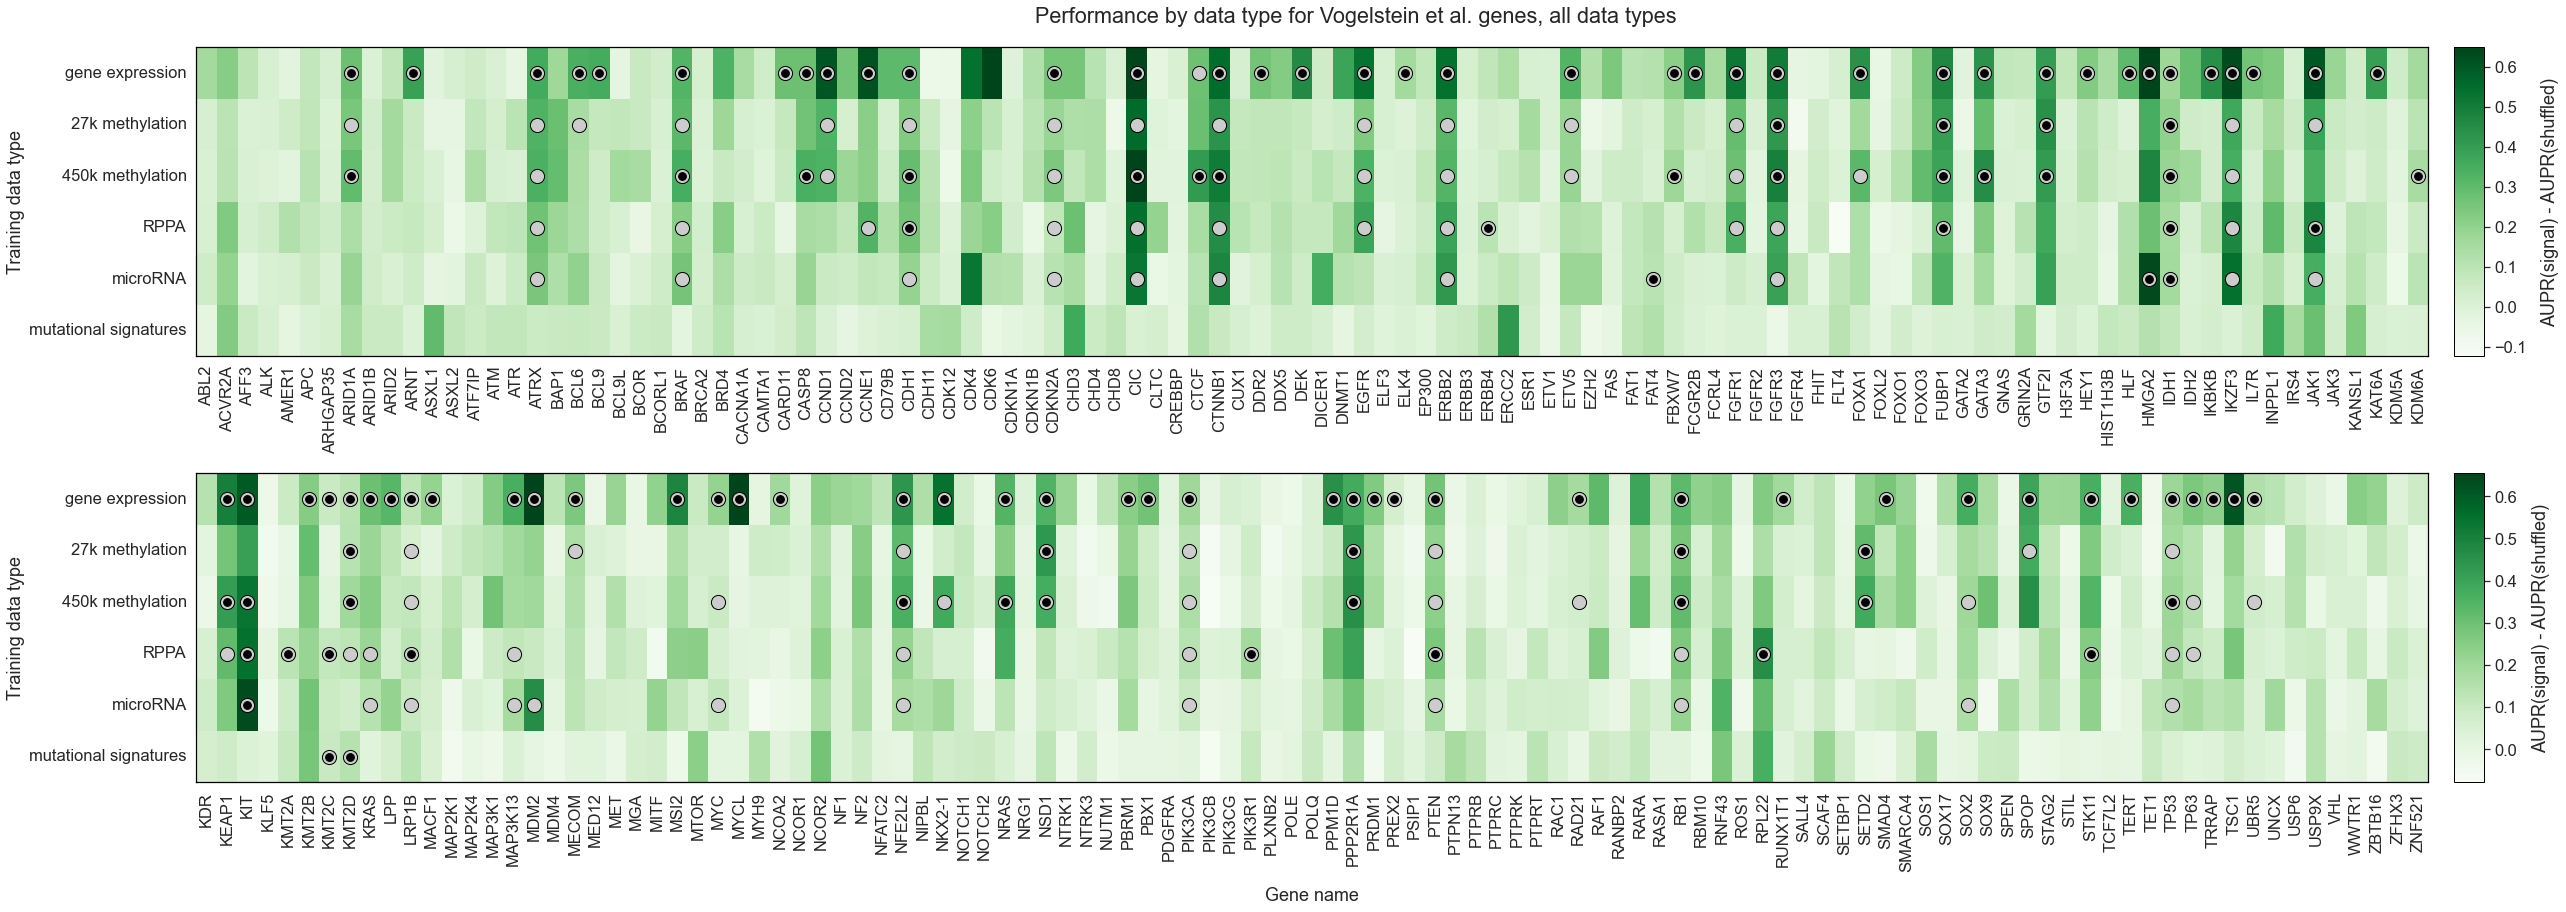

In [16]:
plt.rcParams['svg.fonttype'] = 'path'
if merged_geneset:
    # for the larger gene set we need a bigger figure, since we
    # separate the heatmap into multiple rows
    sns.set({'figure.figsize': (38, 13)})
else:
    sns.set({'figure.figsize': (28, 6)})
    
sns.set_context('notebook', font_scale=1.5)

if merged_geneset:
    ax = plu.plot_heatmap_split(heatmap_df,
                                all_results_df.reset_index(drop=True),
                                results_df,
                                metric=plot_metric,
                                origin_eps_x=0.02,
                                origin_eps_y=0.015,
                                length_x=0.85,
                                length_y=0.95)
    plt.suptitle('Performance by data type for Vogelstein et al. genes, all data types')
    plt.tight_layout()
else:
    ax = plu.plot_heatmap_split(heatmap_df,
                                all_results_df.reset_index(drop=True),
                                results_df,
                                metric=plot_metric,
                                origin_eps_x=0.02,
                                origin_eps_y=0.015,
                                length_x=0.85,
                                length_y=0.95)
    plt.title('Performance by data type for Vogelstein et al. genes, all data types')


if SAVE_FIGS:
    plt.savefig(images_dir / 'all_heatmap.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_heatmap.png',
                dpi=300, bbox_inches='tight')

Key to above heatmap:

* A grey dot = significantly better than label-permuted baseline, but significantly worse than best-performing data type
* A grey dot with black dot inside = significantly better than label-permuted baseline, and not significantly different from best-performing data type (i.e. "statistically equivalent to best")
* No dot = not significantly better than label-permuted baseline